 While we use the area ratio to compare model performance, the area ratio cannot be used to make predictions. In this notebook, we analyze the predictive power of F1, accuracy and weighted accuracy scores.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import set_style
set_style("whitegrid")

In [2]:
df = pd.read_csv("../Data/default.csv", skiprows=1, index_col = "ID")

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_train, df_test = train_test_split(df.copy(),
                                        shuffle = True,
                                        random_state = 167,
                                        test_size = .2,
                                        stratify = df["default payment next month"])

The F1 score is given by 

$$
\text{F}1  = \frac{2*(\text{Precision}*\text{Recall})}{\text{Precision}+ \text{Recall}},
$$
if both precision and recall are non-zero, and 0 otherwise. 

The accuracy is given by

$$
\text{Acc} = \frac{\text{True positives } + \text{ True negatives}}{\text{Total number of cases}}.
$$

We define the weighted accuracy as 

$$
\frac{\text{True positive rate } + \text{ True negative rate}}{2}.
$$

Maximizing the weighted accuracy amounts to minimizing the sum of the False positive and False negative rates. This scoore is more easily adaptable to cost functions. If for instance, a company had the cost function

$$
C = (a_1)*(\text{False positive rate}) + (a_2)*(\text{False negative rate}),
$$

then the modified weighted accuracy score would be 

$$\left(\frac{a_1}{a_1 + a_2}\right)*(\text{True negative rate}) + \left(\frac{a_2}{a_1+a_2}\right)*(\text{True positive rate})$$

In this notebook, we assume $a_1=a_2=1$.

In the next block, we create functions to compute these scores.

In [5]:
from sklearn.metrics import confusion_matrix

#returns in order: (0,0), (0,1), (1,0), (1,1)
def conf_matrix_components(cutoffs, true_data, predicted_prob):
    tp_s=[]
    fp_s=[]
    tn_s=[]
    fn_s=[]
    
    for cutoff in cutoffs:
        pred_cutoff=1*(predicted_prob >=cutoff)
        cmat=confusion_matrix(true_data, pred_cutoff)
        tn = cmat[0][0]
        tp = cmat[1][1]
        fp = cmat[0][1]
        fn = cmat[1][0]
        
        tp_s.append(tp)
        tn_s.append(tn)
        fp_s.append(fp)
        fn_s.append(fn)
        
    return [tn_s, fp_s, fn_s, tp_s]

#precision scores given list of confusion matrix components in order left-to-right and up-to-down
#similarly for the other scores
def prec_scores(list_comps): 
    fp_s=list_comps[1]
    tp_s=list_comps[3]
    prec=np.ones(len(fp_s))
    for i in range(len(tp_s)):
        if tp_s[i]!=0 or fp_s[i]!=0:
            prec[i]=tp_s[i]/(tp_s[i]+fp_s[i])
    return prec;

def recall_scores(list_comps):
    tp_s=list_comps[3]
    fn_s=list_comps[2]
    rec= [tp_s[i]/(tp_s[i]+fn_s[i]) for i in range(len(tp_s))]
    return rec;

def f1_scores(list_comps):
    p=prec_scores(list_comps)
    r=recall_scores(list_comps)
    f1=np.zeros(len(p));
    for i in range(len(p)):
        if p[i]!=0 or r[i]!=0:
            f1[i]= (2*p[i]*r[i])/(p[i]+r[i])
    return list(f1)

def accuracy(list_comps):
    tn, fp, fn, tp = list_comps
    acc=[(tn[i]+tp[i])/(tn[i]+tp[i] + fp[i]+fn[i]) for i in range(len(tp))]
    return acc;

def weighted_accuracy(list_comps):
    #(1/2)*(tn/#true 0s + tp/# true 1s)
    tn, fp, fn, tp = list_comps
    w_acc=[(0.5)*(tn[i]/(tn[i] + fp[i])) + (0.5)*(tp[i]/(tp[i] + fn[i])) for i in range(len(tp)) ]
    return w_acc

In [6]:
def preprocess(df_original):
    df_new = df_original.copy()
    df_new.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
   
    for i in range(1, 7):
        df_new["BILL_FRAC"+str(i)] = df_new["BILL_AMT"+str(i)]/df_new["LIMIT_BAL"]
    for i in range(1, 6):
        df_new["CHARGE_AMT"+str(i)] = df_new["BILL_AMT"+str(i)] - (df_new["BILL_AMT"+str(i+1)] - df_new["PAY_AMT"+str(i)])


    df_new.drop(columns=["LIMIT_BAL", "AGE", "SEX", "EDUCATION", "MARRIAGE"]+["PAY_AMT"+str(i) for i in range(1, 7)], inplace=True)

    return df_new

We start with analyzing the scores of only one of the models. Later we will analyze some more.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def fit_randomforest(X_train, y_train):
    pipe = RandomForestClassifier(n_estimators = 100, max_depth = 7, max_samples = 7000, random_state=36830)
    pipe.fit(X_train, y_train)
    return pipe

In [8]:
X_train= preprocess(df_train).drop(columns=["default payment next month"])
y_train = df_train["default payment next month"]
X_test = preprocess(df_test).drop(columns=["default payment next month"])
y_test = df_test["default payment next month"]

In [9]:
pipe=fit_randomforest(X_train, y_train) #fit random forest model

In [10]:
#predicted probabilities on the training and test set.
predproba_train = pipe.predict_proba(X_train)[:,1]
predproba_test = pipe.predict_proba(X_test)[:,1]

In [11]:
#probability cutoffs
cutoffs=np.arange(1,0,-0.01)

In [12]:
cmat_list_train = conf_matrix_components(cutoffs, y_train.values, predproba_train)
cmat_list_test = conf_matrix_components(cutoffs, y_test.values, predproba_test)

Now that we have our initial set up, let us look at the plots for F1 scores, accuracy and weighted accuracy scores on our training set.

In [13]:
def plot_metrics(cutoffs, true_data, predicted_prob, model_name):
    cmat_list = conf_matrix_components(cutoffs, true_data, predicted_prob)
    x=cutoffs
    y0=f1_scores(cmat_list)
    y1=accuracy(cmat_list)
    y2=weighted_accuracy(cmat_list)
    
    plt.figure(figsize=(10,6))
    
    plt.plot(x, y0, 'r')
    plt.plot(x,y1, 'b')
    plt.plot(x, y2, 'g')
    plt.xlabel('Probability cutoff')
    plt.ylabel('Values')
    plt.legend(['F1', 'Accuracy', 'Weighted accuracy'])
    plt.title('Plot of F1, accuracy and weighted accuracy for '+ model_name)
    
    plt.show()
    
    return None

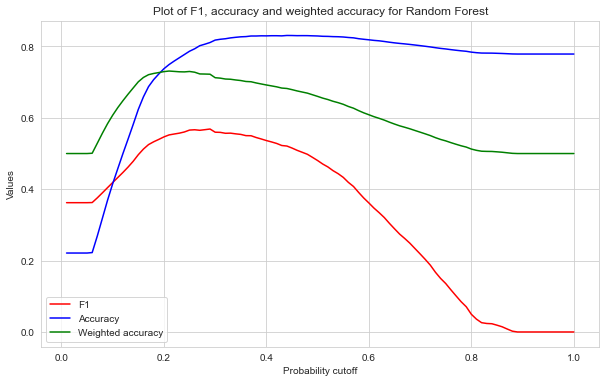

In [14]:
plot_metrics(cutoffs, y_train.values, predproba_train, 'Random Forest')

Recall that our data is imbalanced. Only about 22% of the clients in the sample default, and in reality the percentage is much lower. Accuracy doesn't weight the number of true positives and true negatives by how many actual positives and negatives there are in the data, while F1 and weighted accuracy do. 

We plot the precision and recall separately to illustrate that in this case, a lower probability threshold (provided by F1 or weighted accuracy) is better for prediction. 

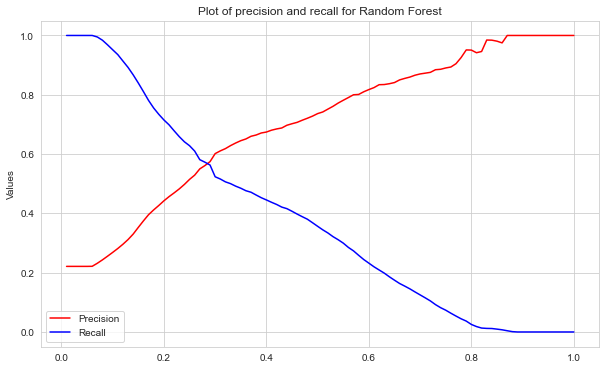

In [15]:
plt.figure(figsize=(10,6))
plt.plot(cutoffs, prec_scores(cmat_list_train) , 'r')
plt.plot(cutoffs, recall_scores(cmat_list_train), 'b')
plt.ylabel('Values')
plt.legend(['Precision', 'Recall'])
plt.title('Plot of precision and recall for Random Forest')
plt.show()

Therefore to optimize recall, we probably do not want a very high cut off. 

In [16]:
def best_cutoffs_singlemodel(y_ho, predicted_prob):
    cutoffs=np.arange(1,0,-0.01)
    cmat_list=conf_matrix_components(cutoffs, y_ho, predicted_prob)
    
    f1=f1_scores(cmat_list)
    f1_max=max(f1)
    f1_max_index=f1.index(f1_max)
    print('The best F1 score for this model is '+ str(f1_max))
    print('Corresponding probability cutoff: ', round(cutoffs[f1_max_index],2))
    pred1=1*(predicted_prob >= cutoffs[f1_max_index])
    print('Proportion of people predicted as defaulters: ', round(sum(pred1)/len(y_ho),3) ) 
    
    print('========================')

    acc=accuracy(cmat_list)
    acc_max=max(acc)
    acc_max_index=acc.index(acc_max)
    print('The best Accuracy score for this model is '+ str(acc_max))
    print('Corresponding probability cutoff: ', round(cutoffs[acc_max_index],2))
    
    pred2=1*(predicted_prob >= cutoffs[acc_max_index])
    print('Proportion of people predicted as defaulters: ', round(sum(pred2)/len(y_ho),3) ) 
    
    print('========================')
    wacc=weighted_accuracy(cmat_list)
    wacc_max=max(wacc)
    wacc_max_index=wacc.index(wacc_max)
    print('The best Weighted Accuracy score for this model is '+ str(wacc_max))
    print('Corresponding probability cutoff: ', round(cutoffs[wacc_max_index],2))
    
    pred3=1*(predicted_prob >= cutoffs[wacc_max_index])
    print('Proportion of people predicted as defaulters: ', round(sum(pred3)/len(y_ho),3) ) 
    print('========================')

Now let's look at the proportion of defaulters predicted by taking the maximum of each score on the training set.

In [17]:
best_cutoffs_singlemodel(y_train, predproba_train)

The best F1 score for this model is 0.5686834094368342
Corresponding probability cutoff:  0.29
Proportion of people predicted as defaulters:  0.217
The best Accuracy score for this model is 0.8308333333333333
Corresponding probability cutoff:  0.44
Proportion of people predicted as defaulters:  0.132
The best Weighted Accuracy score for this model is 0.7311540162356704
Corresponding probability cutoff:  0.21
Proportion of people predicted as defaulters:  0.339


On the other hand, the proportion of defaulters in the training set is:

In [18]:
sum(y_train.values)/len(y_train)

0.22120833333333334

Repeating the same analysis for the test data:

In [19]:
best_cutoffs_singlemodel(y_test, predproba_test)
print('Actual proportion of defaulters: ', sum(y_test.values)/len(y_test))

The best F1 score for this model is 0.5454545454545454
Corresponding probability cutoff:  0.26
Proportion of people predicted as defaulters:  0.257
The best Accuracy score for this model is 0.818
Corresponding probability cutoff:  0.47
Proportion of people predicted as defaulters:  0.122
The best Weighted Accuracy score for this model is 0.7152658790715345
Corresponding probability cutoff:  0.25
Proportion of people predicted as defaulters:  0.274
Actual proportion of defaulters:  0.22116666666666668


In either case, the proportion of people predicted as defaulters by the accuracy score is much lower than the actual proportion; given the nature of the recall curve, this isn't ideal.

We now do a quick comparison across the models from Notebook 3 (3-compare-model-types.ipynb). We first set up all the models.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

def knn(X_train, y_train, X_test, param):
    frac, k = param
    pipe = Pipeline([("scale", StandardScaler()), 
                     ("pca", PCA(frac)), 
                     ("knn", KNeighborsClassifier(k))])
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def lda(X_train, y_train, X_test, param):
    pipe = LinearDiscriminantAnalysis()
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def qda(X_train, y_train, X_test, param):
    pipe = Pipeline([("scale", StandardScaler()), 
                     ("pca", PCA(.9)), 
                     ("qda", QuadraticDiscriminantAnalysis())])
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def naivebayes(X_train, y_train, X_test, param):
    pipe = GaussianNB()
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]


def decisiontree(X_train, y_train, X_test, param):
    d = param[0]
    pipe = DecisionTreeClassifier(max_depth = d)
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def randomforest(X_train, y_train, X_test, param):
    n, d, s = param
    pipe = RandomForestClassifier(n_estimators = n, max_depth = d, max_samples = s)
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def extratrees(X_train, y_train, X_test, param):
    n, d, s = param
    pipe = ExtraTreesClassifier(n_estimators = n, max_depth = d, max_samples = s, bootstrap = True)
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def ada(X_train, y_train, X_test, param):
    n = param[0]
    pipe = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                              n_estimators=n)
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

def gradboost(X_train, y_train, X_test, param):
    n, rate = param
    pipe = GradientBoostingClassifier(n_estimators=n, 
                                     max_depth=1, 
                                     learning_rate=rate)
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

In [21]:
models_list=pd.DataFrame({'knn':[knn, (0.99, 260)],
                            'lda':[lda, (None,)],
                            'qda':[qda, (None,)],
                            'naivebayes':[naivebayes, (None,)],
                            'decisiontree':[decisiontree, (6,)], 
                        'randomforest':[randomforest, (100,7,7000)],
                        'extratrees':[extratrees, (60,5,80)],
                        'ada':[ada, (32,)], 'gradboost':[gradboost, (96, 0.4)] })

We now create a function that will calculate and store the maximum of each of the F1, accuracy and weighted accuracy score, the corresponding probability cutoff, and the proportion of people predicted to default. 

In [22]:
def best_scores(predicted_prob, y_ho):
    cmat_list=conf_matrix_components(np.arange(1,0,-0.01), y_ho, predicted_prob)
    
    #matrix to store the maximum metric score, the corresponding probability cutoff, 
    #and the predicted proportion of default
    scores=np.zeros((3,3)) 
    
    f1=f1_scores(cmat_list)
    f1_max=max(f1)
    f1_max_index=f1.index(f1_max)
    scores[0][0]=f1_max
    scores[0][1] = round(cutoffs[f1_max_index],2)
    pred1=1*(predicted_prob >= cutoffs[f1_max_index])
    scores[0][2] = round(sum(pred1)/len(y_ho),3) 
    
    #-----------------
    
    wacc=weighted_accuracy(cmat_list)
    wacc_max=max(wacc)
    wacc_max_index=wacc.index(wacc_max)
    scores[1][0]=wacc_max
    scores[1][1] = round(cutoffs[wacc_max_index],2)
    pred2=1*(predicted_prob >= cutoffs[wacc_max_index])
    scores[1][2] = round(sum(pred2)/len(y_ho),3) 
    
    #------------------
    
    acc=accuracy(cmat_list)
    acc_max=max(acc)
    acc_max_index=acc.index(acc_max)
    scores[2][0]=acc_max
    scores[2][1] = round(cutoffs[acc_max_index],2)
    pred3=1*(predicted_prob >= cutoffs[acc_max_index])
    scores[2][2] = round(sum(pred3)/len(y_ho),3) 
    
    return scores;

We will store all our values in a dataframe, which will compare how these metrics on the training and test data.

In [41]:
def run_comparison(X_train, y_train, X_test,  y_test, models_list):
    comparison_df=pd.DataFrame()
    comparison_df['Model_Name']=models_list.columns
    #create arrays for each of the columns in the dataframe.
    maxf1=[];
    maxwacc=[];
    maxacc=[];
    cutf1=[];
    cutwacc=[];
    cutacc=[];
    predf1=[];
    predwacc=[];
    predacc=[];
    for model in models_list.columns:
        model_fn=models_list[model][0]
        param=models_list[model][1]
        predict=model_fn(X_train, y_train, X_test, param)
        scores=best_scores(predict, y_test)
    
        #append scores
        maxf1.append(scores[0][0]);
        maxwacc.append(scores[1][0]);
        maxacc.append(scores[2][0]);
        cutf1.append(scores[0][1]);
        cutwacc.append(scores[1][1]);
        cutacc.append(scores[2][1]);
        predf1.append(scores[0][2])
        predwacc.append(scores[1][2]);
        predacc.append(scores[2][2]);

    #create data frame with all these metrics
    comparison_df['Max_F1']=maxf1
    comparison_df['Max_Wtd_Acc']=maxwacc
    comparison_df['Max_Acc']=maxacc
    comparison_df['Cutoff_F1']=cutf1
    comparison_df['Cutoff_Wtd_Acc']=cutwacc
    comparison_df['Cutoff_Acc']=cutacc
    comparison_df['Pred_Default_F1']=predf1
    comparison_df['Pred_Default_Wtd_Acc']=predwacc
    comparison_df['Pred_Default_Acc']=predacc
    
    return comparison_df

In [38]:
comparison_train=run_comparison(X_train, y_train, X_train, y_train, models_list)

In [39]:
comparison_train

,Model_Name,Max_F1,Max_Wtd_Acc,Max_Acc,Cutoff_F1,Cutoff_Wtd_Acc,Cutoff_Acc,Pred_Default_F1,Pred_Default_Wtd_Acc,Pred_Default_Acc
0,knn,0.522618,0.702542,0.810167,0.22,0.20,0.40,0.282,0.328,0.115
1,lda,0.521241,0.696883,0.815542,0.24,0.24,0.47,0.258,0.258,0.101
2,qda,0.509236,0.689705,0.805583,0.44,0.38,0.70,0.228,0.271,0.115
3,naivebayes,0.479401,0.665306,0.807042,0.44,0.44,0.55,0.213,0.213,0.110
4,decisiontree,0.543725,0.716112,0.828083,0.28,0.22,0.58,0.186,0.327,0.112
5,randomforest,0.568530,0.730763,0.831333,0.27,0.22,0.50,0.231,0.311,0.109
6,extratrees,0.529889,0.704663,0.811500,0.23,0.23,0.38,0.272,0.272,0.115
7,ada,0.534252,0.710515,0.818000,0.49,0.49,0.50,0.293,0.293,0.105
8,gradboost,0.547964,0.718622,0.820875,0.24,0.20,0.47,0.256,0.336,0.119


From the table, the standard F1 score appears to be a better predictor, with weighted accuracy being a close second in some cases. Let's test this on the test data.

In [43]:
comparison_test=run_comparison(X_train, y_train, X_test, y_test, models_list)

In [44]:
comparison_test

,Model_Name,Max_F1,Max_Wtd_Acc,Max_Acc,Cutoff_F1,Cutoff_Wtd_Acc,Cutoff_Acc,Pred_Default_F1,Pred_Default_Wtd_Acc,Pred_Default_Acc
0,knn,0.518748,0.699667,0.807333,0.23,0.20,0.40,0.263,0.324,0.116
1,lda,0.509572,0.688714,0.812333,0.24,0.24,0.45,0.258,0.258,0.114
2,qda,0.512126,0.689342,0.800667,0.42,0.39,0.70,0.246,0.270,0.119
3,naivebayes,0.467553,0.657121,0.803000,0.45,0.45,0.61,0.192,0.192,0.089
4,decisiontree,0.519695,0.701234,0.819000,0.23,0.22,0.64,0.304,0.326,0.097
5,randomforest,0.546619,0.712903,0.820833,0.26,0.24,0.49,0.247,0.275,0.121
6,extratrees,0.504659,0.691637,0.809667,0.25,0.21,0.33,0.226,0.334,0.145
7,ada,0.518995,0.699584,0.815167,0.49,0.49,0.50,0.296,0.296,0.106
8,gradboost,0.538012,0.708444,0.819333,0.29,0.20,0.43,0.206,0.329,0.134
